# Idea #
1) convert to grayscale image

2) whiten black pixels

3) threshold to get binary of cells

4) slide window over binary image:
   if the mean of pixels in the sliding window is below a threshold, then index into real image, apply random rotation, and save

Question: For ground truth, do we need access to the whole image to "fill in" the annotation polygons?

If so, load entire image into memory, fill in polygon, then overwrite ground truth with "filled-in" version

Then, when indexing into real image, also index into ground truth file and save

Current code: loads a sample from the image, since whole image won't fit into memory.

Important to note: When using the method getUCharPatch(), you get a numpy array that is indexed like a normal matrix (Row, Column)). But the image is indexed by (Column, Row). So when saving the 300x300 sample, reverse the indices

Alternative to sliding window over entire image, uniformly random sample indices from binary thresholded image. Then perform sliding window over a local area around the random sample
   

In [1]:
import multiresolutionimageinterface as mir
from skimage import io, exposure
from skimage.morphology import binary_dilation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage import img_as_uint
from os import listdir
from os.path import isfile, join, basename
import time
import os, sys
from openslide import OpenSlide

import argparse


#TODO: add help methods
#      clean up unused arguments
def get_arguments():
    parser=argparse.ArgumentParser(description='takes a data directory and looks\
                                   for tif/mask file combos to generate a glimpses\
                                  of larger images to be used as training examples')
    parser.add_argument('--rootdir',type=str,default='/media/kenleejr92/Untitled1/CAMELYON_2017',
                       help='main directory containing all tif and mask files.\
                        Program assumes all tif files within are either \
                        mask, input, or output files')
    parser.add_argument('--maskdir',type=str,default='/media/kenleejr92/Untitled1/CAMELYON_2017/lesion_masks',help='directory containing mask files that match tif filenames')
    parser.add_argument('--outputdir',type=str,default='/media/kenleejr92/Untitled1/CAMELYON_2017/training_samples')
    parser.add_argument('--samples_per_image',type=int,default=300)
    parser.add_argument('--ds_level',type=int,default=8)
    parser.add_argument('--sampling_level',default=0)
    parser.add_argument('--window_size',type=int,default= 300)
    parser.add_argument('--border_multiplier',type=int,default=2)
    parser.add_argument('--method',default='random')
    parser.add_argument('--display_samples',type=bool, default=False)
    parser.add_argument('--stride',default=150)
    parser.add_argument('--year',type=str, default='2017')
    parser.add_argument('--seed',type=int, default=1234)
    return parser.parse_args()


#first whitens black pixels then performs otsu threshold
def threshold(image):
    gray_img = rgb2gray(image)
    # whiten black pixels
    black = np.where(gray_img < 0.1)
    gray_img[black] = 1.0
    # threshold to get cells
    try:
        thresh = threshold_otsu(gray_img)
        binary = gray_img > thresh
    except:
        binary = None
    return binary

def sample_window(mr_image, pixel, window_size, sampling_level):
    x, y = pixel
    if(y-window_size/2 < 0) or (x-window_size/2 < 0):
        return None
    else:
        sample_300x300 = mr_image.getUCharPatch(y-window_size/2,\
                                                x-window_size/2,\
                                                window_size,window_size,\
                                                sampling_level)
        return sample_300x300

def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)


def mkdir(dire):
    if not os.path.exists(dire):
        print 'making new directory:',dire
        os.makedirs(dire)

def sliding_window(input_file,
                   output_dir,
                   stride=150,
                   sample_dim = 300,
                   sampling_level=0):
    '''
    This function takes a multiresolution tif file and outputs a directory
    of sliding window files that tile that image

    It skips very dark and very light images

    '''
    if not os.path.exists(input_file):
        raise ValueError('file %s does not exist'% input_file)


    base_name_dot_tif=os.path.basename(input_file)
    base_name,ftype=base_name_dot_tif.split('.')
    assert ftype in ['tif','tiff']
    pt_window_dir=os.path.join(output_dir,base_name)
    mkdir(pt_window_dir)
    _,patient, _,node= base_name.split('_')

    reader = mir.MultiResolutionImageReader()
    mr_image = reader.open(input_file)
    r, c = mr_image.getDimensions()
    ds = mr_image.getLevelDownsample(sampling_level)

    n_skipped_dark,n_skipped_light=0,0
    print('Sampling from input_file: %s' % input_file)
    for i in np.arange(0,int(c/ds),stride):
        print 'col ',i,' outof ',int(c/ds)
        for j in np.arange(0,int(r/ds),stride):
            sample_300x300 = mr_image.getUCharPatch(int(j*ds),int(i*ds),sample_dim,sample_dim,sampling_level)
            gray_300x300 = rgb2gray(sample_300x300)
            mean = np.mean(gray_300x300)
            if mean <0.1:
                n_skipped_dark+=1
            elif mean>0.97:
                n_skipped_light+=1
            else:
                print('saving sample')
                fname=os.path.join(pt_window_dir,'patient_%s_%s_%s_%s.jpg' % (patient,node,j,i) )
                io.imsave(fname, sample_300x300)
    print 'skipped ',n_skipped_light,' windows due to white'
    print 'skipped ',n_skipped_dark,' windows due to black'

############################
# generate_training_samples
# generates 300x300 samples from image at highest resolution (level=0)
# rootdir = where your images are e.g. /home/kenleejr92/CAMELYON_2017
# samples_per_image = how many pixels to sample per .tif
# Note: each pixel sampled will then generate many training images from sliding window
# ds_level = down sample level at which thresholding and random sampling of pixels is performed
# window_size = once a random pixel is sampled, a window surrounding the pixel is retrieved at highest resolution
#               a sliding window of size 300x300 is then passed over the window and saved along with ground truth
# stride = stride of sliding window
#(y*ds,x*ds) is index of random pixel at lowest resolution
###########################
def generate_training_samples(rootdir='/home/kenleejr92/Desktop',
                              maskdir='/home/kenleejr92/Desktop/masks',
                              outputdir='/home/kenleejr92/Desktop/CAMELYON_2017/training_samples',
                              samples_per_image=300,
                              ds_level=8,
                              sampling_level=3,
                              window_size = 500,
                              border_multiplier=2,
                              method='random',#random or sliding window
                              display_samples=True,
                              stride=150,
                              year='2017',
                              seed=1234):
    mkdir(rootdir)
    mkdir(maskdir)
    mkdir(outputdir)
    text_file_dir=outputdir+'/text_files/'
    mkdir(text_file_dir)

    np.random.seed(1234)
    sample_dim = 300
    reader = mir.MultiResolutionImageReader()
    f = open(rootdir+'/training.txt', 'w+')
    no_mask_file = np.zeros((300,300), np.int8)
    tar_dir='/CAMELYON_%s/training_samples' % year
    

    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            filepath = subdir + os.sep + file
            #Checks for all files ending with ".tif" not maskdir or outputdir
            if filepath.endswith(".tif") and subdir != outputdir and subdir != maskdir:
                print('Sampling from file: %s' % file)
                parse = file.split('_')
                patient_num=parse[1]
                node=parse[3].split('.')[0]
                #1 file for all patients
                #f1= open(text_file_dir+'patient_%s_node_%s.txt' % (patient_num, node), 'w+')
                f1= open(text_file_dir+'dataset.txt', 'a')#append
                imagedir = outputdir + '/patient_%s_node_%s' % (patient_num, node)
                ensure_dir(imagedir)
                tartxt_dir = tar_dir + '/patient_%s_node_%s' % (patient_num, node)

                #Check if has a mask file
                has_ground_truth = False
                if os.path.isfile(maskdir+'/patient_%s_node_%s_mask.tif' % (patient_num, node)):
                    ground_truth = reader.open(maskdir+'/patient_%s_node_%s_mask.tif' % (patient_num, node))
                    has_ground_truth = True
                else:
                    print 'no ground truth for %s_node_%s' % (patient_num,node),
                    print '..ignoring'
                    continue

                #Read downsampled image
                mr_image = reader.open(filepath)
                r, c = mr_image.getDimensions()
                ds = mr_image.getLevelDownsample(ds_level)
                sl = mr_image.getLevelDownsample(sampling_level)
                try:
                    #we were getting error:
                    #OverflowError: in method MultiResolutionImage_getUCharPatch,
                    #argument 4 of type unsigned long long
                    image_patch = mr_image.getUCharPatch(0,0,np.int(r/ds),np.int(c/ds),ds_level)
                except Exception as ex:
                    print type(ex)
                    print ex.args
                    print ex
                    continue


                if method == 'random':
                    ###################random sampling of pixels##################
                    binary = threshold(image_patch)
                    cell_pixels = np.where(binary==False)
                    cell_pixels = zip(cell_pixels[0], cell_pixels[1])
                    gt = ground_truth.getUCharPatch(0,0,np.int(r/ds),np.int(c/ds),ds_level)
                    gt = gt.reshape((np.int(c/ds),np.int(r/ds)))
                    gt_dilated = binary_dilation(gt,selem=np.ones((8,8)))
                    dilated_pixels = np.where(gt_dilated==1.0)
                    dilated_pixels = zip(dilated_pixels[0],dilated_pixels[1])
                    dilated_pixels = set(dilated_pixels)
                    tumor_pixels = np.where(gt==1.0)
                    tumor_pixels = zip(tumor_pixels[0],tumor_pixels[1])
                    tumor_pixels = set(tumor_pixels)
                    border_pixels = dilated_pixels.difference(tumor_pixels)
                    border_pixels = list(border_pixels)
                    cell_pixels = set(cell_pixels)
                    normal_pixels = cell_pixels.difference(tumor_pixels)
                    tumor_pixels = list(tumor_pixels)
                    normal_pixels = list(normal_pixels)
                    rand_border_indices = np.arange(0,len(border_pixels))
                    rand_tumor_indices = np.arange(0,len(tumor_pixels))
                    rand_normal_indices = np.arange(0,len(normal_pixels))
                    rand_border_pixels = []
                    #This is some hack: because sometimes this is a problem
                    if len(rand_border_indices)==0:
                        print 'border method fails:patient:',patient_num,' node:',node
                        continue
                    for i in range(border_multiplier):
                        rand_border_pixels = rand_border_pixels + list(np.random.choice(rand_border_indices, size=samples_per_image))
                    rand_tumor_pixels = np.random.choice(rand_tumor_indices, size=samples_per_image)
                    rand_normal_pixels = np.random.choice(rand_normal_indices, size=samples_per_image)
                    center_pixels = []
                    for i in rand_tumor_pixels:
                        center_pixels.append(tumor_pixels[i])
                    for i in rand_normal_pixels:
                        center_pixels.append(normal_pixels[i])
                    for i in rand_border_pixels:
                        center_pixels.append(border_pixels[i])
                    ################################################################

                    if display_samples:
                        copy = np.copy(image_patch)
                        for x,y in center_pixels:
                            copy[x,y,:] = [255,0,0]
                        io.imshow(copy)
                        io.show()

                    for x,y in center_pixels:
                        pixel = (np.int(y*ds)-window_size/2,np.int(x*ds)-window_size/2)
                        print('Creating sample around pixel: (%s,%s)' % pixel)
                        #sample an area of image with center point the randomly selected pixel index
                        sample_300x300 = mr_image.getUCharPatch(pixel[1],pixel[0],sample_dim,sample_dim,sampling_level)
                        if sample_300x300 is None:
                            print('sample out of bounds')
                            continue
                        binary = threshold(sample_300x300)
                        if binary is None:
                            print('rejecting sample for sparsity')
                            continue
                        mean = np.mean(binary)
                        if mean < 0.97:
                            y1 = pixel[1]
                            x1 = pixel[0]
                            io.imsave(imagedir+'/patient_%s_%s_%s_%s.jpg' % (patient_num,node,y1,x1),\
                                      sample_300x300)
                            if has_ground_truth == True:
                                ground_truth_300x300 = ground_truth.getUCharPatch(y1,x1,sample_dim,sample_dim,sampling_level)
                                ground_truth_300x300 = ground_truth_300x300.reshape(sample_dim,sample_dim)
                                io.imsave(imagedir+'/patient_%s_%s_%s_%s_gt.png' % \
                                          (patient_num,node,y1,x1), ground_truth_300x300)
                                f.write(tartxt_dir+'/patient_%s_%s_%s_%s.jpg '  % (patient_num,node,y1,x1)\
                                        + tartxt_dir+'/patient_%s_%s_%s_%s_gt.png\n' % (patient_num,node,y1,x1))
                                f1.write(tartxt_dir+'/patient_%s_%s_%s_%s.jpg '  % (patient_num,node,y1,x1)\
                                        + tartxt_dir+'/patient_%s_%s_%s_%s_gt.png\n' % (patient_num,node,y1,x1))
                            else:
                                ground_truth_300x300 = no_mask_file
                                io.imsave(imagedir+'/patient_%s_%s_%s_%s_gt.png' % \
                                          (patient_num,node,y1,x1), ground_truth_300x300)
                                f.write(tartxt_dir+'/patient_%s_%s_%s_%s.jpg '  % (patient_num,node,y1,x1)\
                                        + tartxt_dir+'/patient_%s_%s_%s_%s_gt.png\n' % (patient_num,node,y1,x1))
                                f1.write(tartxt_dir+'/patient_%s_%s_%s_%s.jpg '  % (patient_num,node,y1,x1)\
                                        + tartxt_dir+'/patient_%s_%s_%s_%s_gt.png\n' % (patient_num,node,y1,x1))
                        else: print('rejecting sample for sparsity')

                elif(method=='sliding_window'):
                    for i in np.arange(0,c,stride):
                        for j in np.arange(0,r,stride):
                            sample_300x300 = mr_image.getUCharPatch(j,i,sample_dim,sample_dim,sampling_level)
                            gray_300x300 = rgb2gray(sample_300x300)
                            mean = np.mean(gray_300x300)
                            if mean > 0.1:
                                print('saving sample')
                                sys.exit(0)
                                io.imsave(imagedir+'/patient_%s_%s_%s_%s.jpg' % (patient_num,node,j,i),\
                                          sample_300x300)
                                if has_ground_truth == True:
                                    ground_truth_300x300 = ground_truth.getUCharPatch(j,i,sample_dim,sample_dim,sampling_level)
                                    ground_truth_300x300 = ground_truth_300x300.reshape(sample_dim,sample_dim)
                                    io.imsave(imagedir+'/patient_%s_%s_%s_%s_gt.png' % \
                                              (patient_num,node,j,i), ground_truth_300x300)
                                    f.write(tartxt_dir+'/patient_%s_%s_%s_%s.jpg '  % (patient_num,node,j,i)\
                                            + tartxt_dir+'/patient_%s_%s_%s_%s_gt.png\n' % (patient_num,node,j,i))
                                else:
                                    ground_truth_300x300 = no_mask_file
                                    io.imsave(imagedir+'/patient_%s_%s_%s_%s_gt.png' % \
                                              (patient_num,node,j,i), ground_truth_300x300)
                                    f.write(tartxt_dir+'/patient_%s_%s_%s_%s.jpg '  % (patient_num,node,j,i)\
                                            + tartxt_dir+'/patient_%s_%s_%s_%s_gt.png\n' % (patient_num,node,j,i))
                f1.close()
    f.close()

# if __name__ == '__main__':
#     args=get_arguments()
#     kwargs= vars(args)
#     generate_training_samples( **kwargs)





making new directory: /home/kenleejr92/Desktop/CAMELYON_2017/training_samples/text_files/
Sampling from file: patient_017_node_2.tif


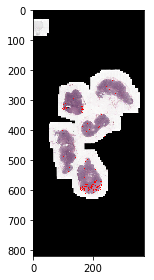

Creating sample around pixel: (52110,156062)
rejecting sample for sparsity
Creating sample around pixel: (56987,150928)
rejecting sample for sparsity
Creating sample around pixel: (51854,152212)
rejecting sample for sparsity
Creating sample around pixel: (52880,151955)
rejecting sample for sparsity
Creating sample around pixel: (49030,154265)
rejecting sample for sparsity
Creating sample around pixel: (51597,151185)
rejecting sample for sparsity
Creating sample around pixel: (51597,156318)
rejecting sample for sparsity
Creating sample around pixel: (54934,147078)
rejecting sample for sparsity
Creating sample around pixel: (55447,151185)
rejecting sample for sparsity
Creating sample around pixel: (54934,146822)
rejecting sample for sparsity
Creating sample around pixel: (55190,150672)
rejecting sample for sparsity
Creating sample around pixel: (53137,153238)
rejecting sample for sparsity
Creating sample around pixel: (54164,154265)
rejecting sample for sparsity
Creating sample around pi

In [51]:
generate_training_samples()

In [156]:
generate_training_samples(rootdir='/home/kenleejr92/Desktop',\
                          maskdir='/home/kenleejr92/Desktop/masks',\
                          outputdir='/home/kenleejr92/Desktop/CAMELYON_2017/training_samples',\
                          display_samples=False,\
                          method='random')

Sampling from file: patient_017_node_2.tif
Creating sample around pixel: (52210,156162)
Creating sample around pixel: (57087,151028)
Creating sample around pixel: (51954,152312)
Creating sample around pixel: (52980,152055)
Creating sample around pixel: (49130,154365)
Creating sample around pixel: (51697,151285)
Creating sample around pixel: (51697,156418)
Creating sample around pixel: (55034,147178)
Creating sample around pixel: (55547,151285)
Creating sample around pixel: (55034,146922)
Creating sample around pixel: (55290,150772)
Creating sample around pixel: (53237,153338)
Creating sample around pixel: (54264,154365)
Creating sample around pixel: (55547,153338)
Creating sample around pixel: (54264,146152)
Creating sample around pixel: (55290,150515)
Creating sample around pixel: (56060,150002)
Creating sample around pixel: (45537,153595)
Creating sample around pixel: (52210,152568)
Creating sample around pixel: (45280,154365)
Creating sample around pixel: (46307,153595)
Creating sam

KeyboardInterrupt: 

/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_54519_150514.jpg


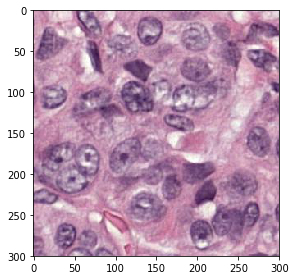

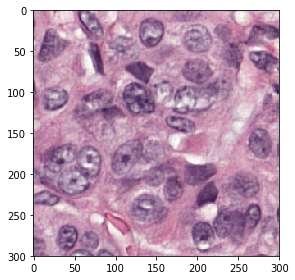

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [ True False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_50156_152824.jpg


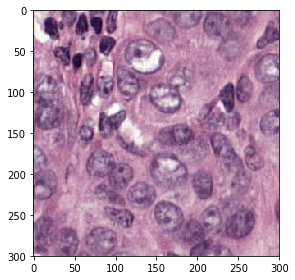

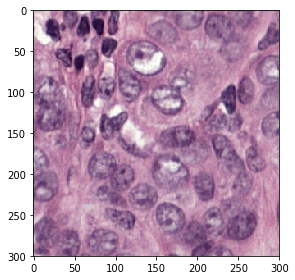

[[[False False False]
  [False False  True]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [ True False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_55289_153851.jpg


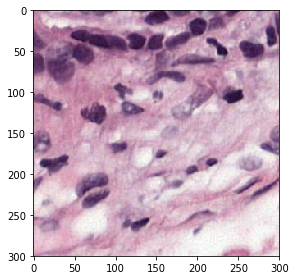

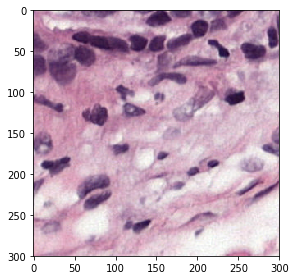

[[[False False False]
  [False False False]
  [False False  True]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False  True]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_45792_152567.jpg


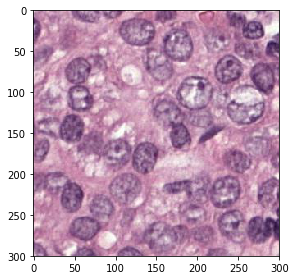

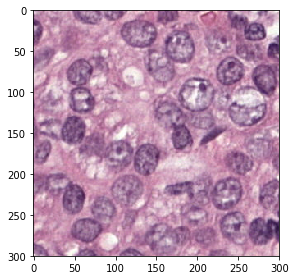

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False  True False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_43996_151541.jpg


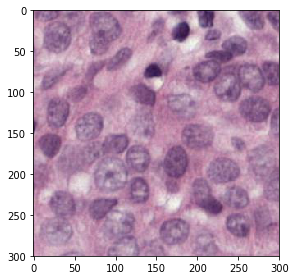

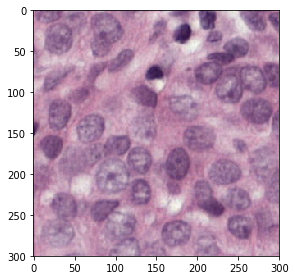

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [ True False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_43226_153337.jpg


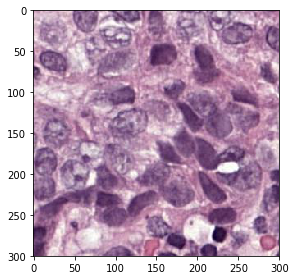

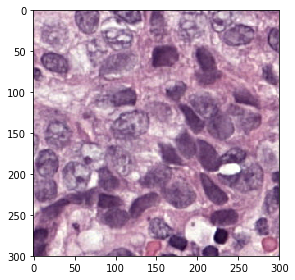

[[[False False False]
  [ True False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False  True False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[ True False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_43739_151797.jpg


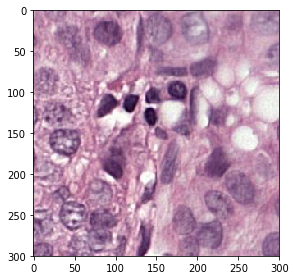

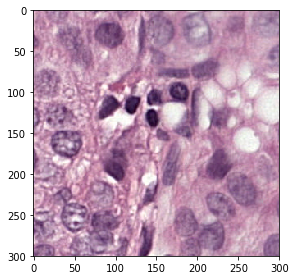

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_52209_150771.jpg


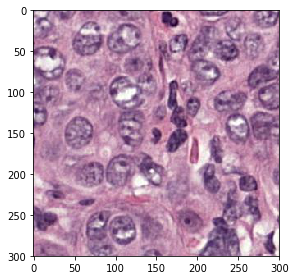

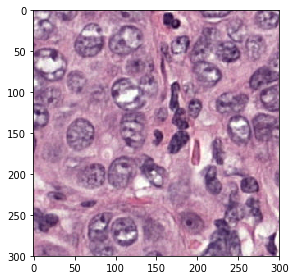

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False  True]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_48873_153594.jpg


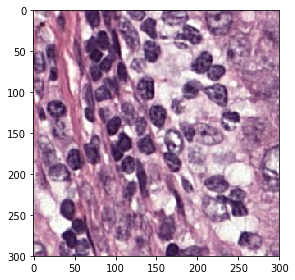

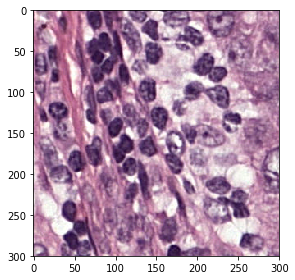

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False  True False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False  True]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False  True]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_57086_148717.jpg


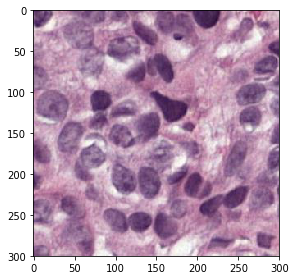

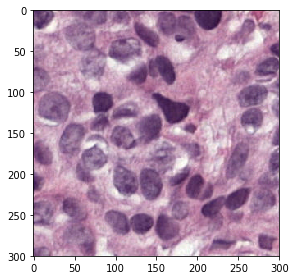

[[[False False False]
  [False False False]
  [False False  True]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [ True  True False]
  [ True False False]
  ..., 
  [False False False]
  [False False  True]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False  True False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_51953_152311.jpg


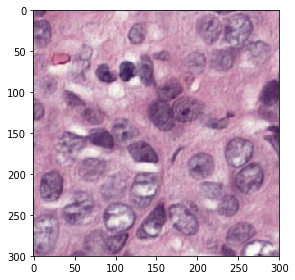

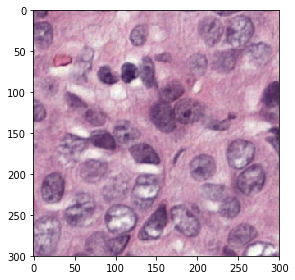

[[[False False False]
  [False False False]
  [False False  True]
  ..., 
  [False False False]
  [False False False]
  [False  True False]]

 [[False False False]
  [ True False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False  True]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_55546_151284.jpg


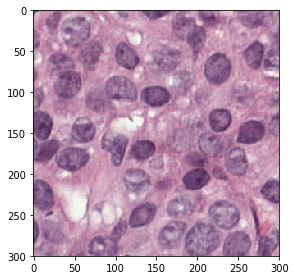

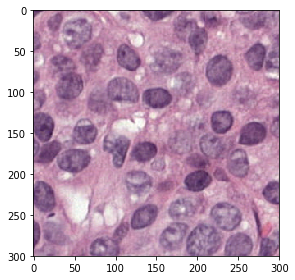

[[[False False  True]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [ True False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_56059_150001.jpg


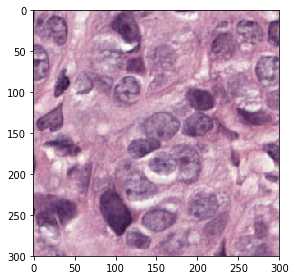

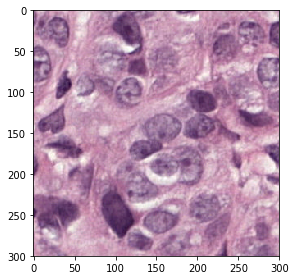

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [ True False  True]
  [False  True  True]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False  True False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_50926_152567.jpg


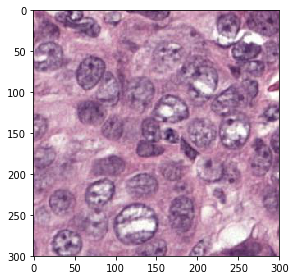

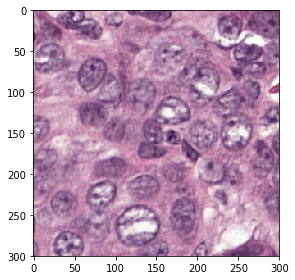

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [ True False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False  True]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_51439_155904.jpg


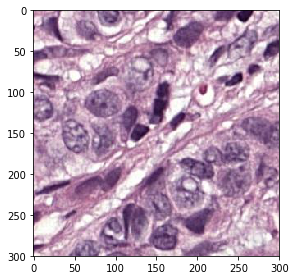

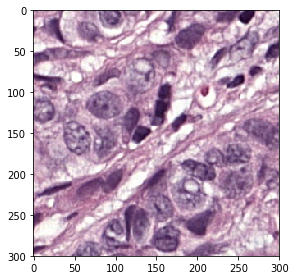

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [ True False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False  True  True]
  [False False False]
  [False False  True]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_50413_150771.jpg


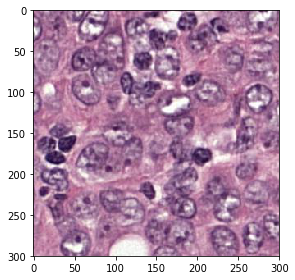

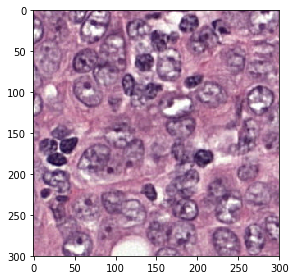

[[[ True False False]
  [False False  True]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False  True]
  [False False  True]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_42199_150771.jpg


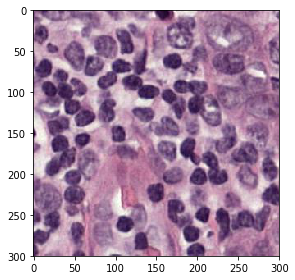

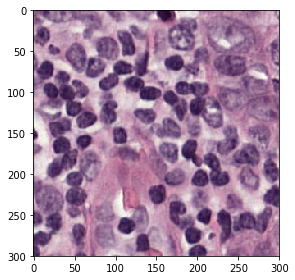

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_49643_155391.jpg


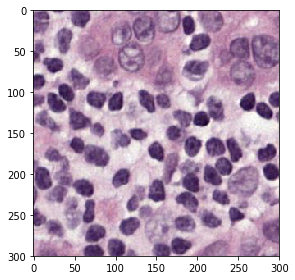

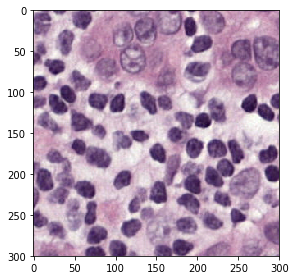

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False  True False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_55546_147177.jpg


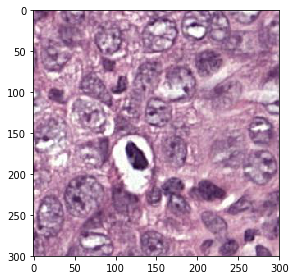

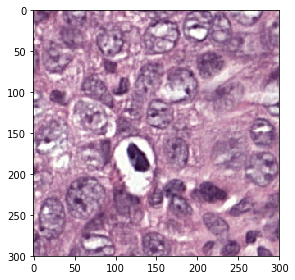

[[[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 ..., 
 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ..., 
  [False False False]
  [False False False]
  [False False  True]]]
/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/patient_017_2_42199_84806.jpg


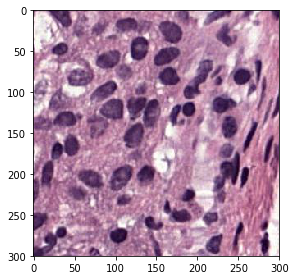

KeyboardInterrupt: 

In [157]:
def check_coordinates(training_dir='/home/kenleejr92/Desktop/CAMELYON_2017/training_samples/patient_017_node_2/'):
    #sample file name is encoded as patient_XXX_node_y_x.tif
    #(x1,y1) is the index of the random point selected uniformly at downsample level
    #(h1,v1) is the pixel offset at the highest resolution to get the top left corner of the sample
    #top left corner at highest resolution is then (y2 = ds*y1+v1,x2 = ds*x1+h1)
    def decode_filename(filename):
        elements = filename.split('_')
        patient = elements[1]
        node = elements[2]
        y = int(elements[3])
        x = int(elements[4].split('.')[0])
        return patient, node, y, x
    sample_dim = 300
    lowest_level = 0
    mypath = training_dir
    onlyfiles = [f for f in listdir(mypath) if isfile(join(training_dir, f))]
    i=0
    for filename in onlyfiles:
        if filename.endswith(".png"): continue
        if(i==20): break
        patient, node, y, x = decode_filename(filename)
        img = io.imread(mypath+filename)
        print(mypath+filename)
        io.imshow(img)
        io.show()
        reader = mir.MultiResolutionImageReader()
        mr_image = reader.open('/home/kenleejr92/Desktop/patient_017_node_2.tif')
        actual = mr_image.getUCharPatch(y-1,x-1,sample_dim,sample_dim, lowest_level)
        io.imshow(actual)
        io.show()
        print(img == actual)
        i = i +1
        
check_coordinates()

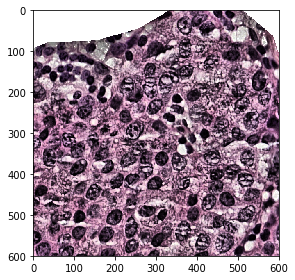

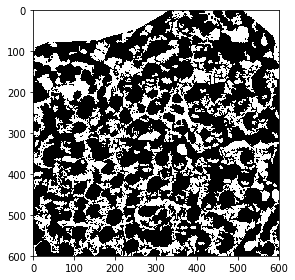

166


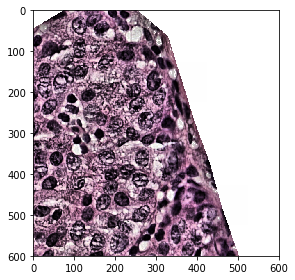

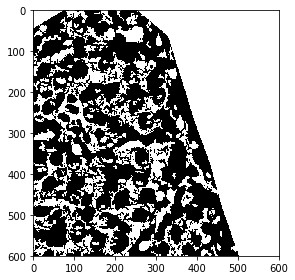

146


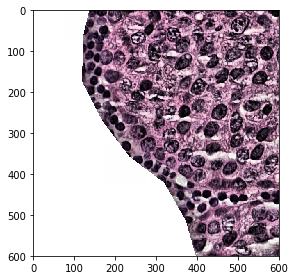

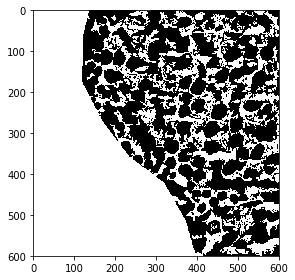

73


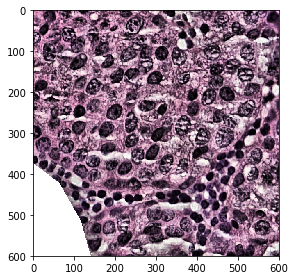

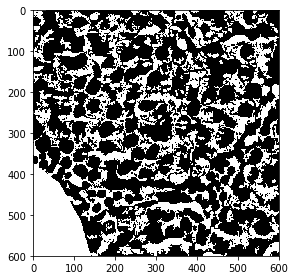

136


KeyboardInterrupt: 

In [172]:
np.random.seed(1234)
reader = mir.MultiResolutionImageReader()
mr_image = reader.open('/home/kenleejr92/Desktop/patient_017_node_2.tif')
ds_level = 8
sampling_level = 0
r, c = mr_image.getDimensions()
ds = mr_image.getLevelDownsample(ds_level)
image_patch = mr_image.getUCharPatch(0,0,int(r/ds),int(c/ds),ds_level)
ground_truth = reader.open('/home/kenleejr92/Desktop/masks/patient_017_node_2_mask.tif')
gt = ground_truth.getUCharPatch(0,0,int(r/ds),int(c/ds),ds_level)
gt = gt.reshape((int(c/ds),int(r/ds)))
tumor_pixels = np.where(gt==1.0)
tumor_pixels = zip(tumor_pixels[0],tumor_pixels[1])
x,y = tumor_pixels[200]
for x,y in tumor_pixels:
    pixel = (int(x*ds),int(y*ds))
    sample_300x300 = sample_window(mr_image, pixel, 600, sampling_level)
    gt_300x300 = sample_window(ground_truth, pixel, 600, sampling_level).reshape((600,600))
    tumor = np.where(gt_300x300==0.0)
    tumor = zip(tumor[0],tumor[1])
    for x,y in tumor:
        sample_300x300[x,y,:] = [255,255,255]
    img = equalize_adapthist(sample_300x300, kernel_size = (50,50), clip_limit = 0.5)
    io.imshow(img)
    io.show()
    gray_img = rgb2gray(img)
    thresh = threshold_otsu(gray_img)
    binary = gray_img > 0.5
    binary = remove_small_objects(binary, connectivity=3)
    io.imshow(binary)
    io.show()
    all_labels, num = measure.label(binary,return_num=True,background=0)
    print num

In [62]:
equalize_adapthist?